<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
E-learning course on <br / ><br / >
Advanced Neutron Imaging
</p> 

# Basic segmentation

Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

## Introduction 
In many analysis applications it is needed to identify different regions of the image. This tutorial will show how you can do this with help of tresholds.

### What you will learn

### Required knowledge
This tutorial needs the previous image processing tutorials in this e-learning section
- Introduction to images
- Noise 
- Filters


### We need some packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tifffile as tiff
import skimage.filters as flt
import skimage.morphology as morph
from scipy.ndimage import convolve
import sys

if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf ImageProcessing
    !git clone https://github.com/ImagingELearning/ImageProcessing.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/ImageProcessing/tutorials/00_common/data/"
    %pushd .
    %cd /content/ImageProcessing/tutorials/00_common/data
    !unzip beads.zip
    %popd
    sys.path.append("/content/scripts/python/")
    sys.path.append("/content/ImageProcessing/tutorials/00_common/")
else: 
    # Running locally on your computer
    data_path = "../00_common/data/"
    sys.path.append('../00_common/')

import readers as rd
    

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Revisiting the histogram

### Test images and their histograms

### The bi-level image
The first image is a bi-level image. It has the advantage that we can modify it by adding noise and blurring to mimic a real image and still have a ground truth to compare the segmentation performance with.

It is a 3D image and as you can see in the histogram we only have two levels in this image.

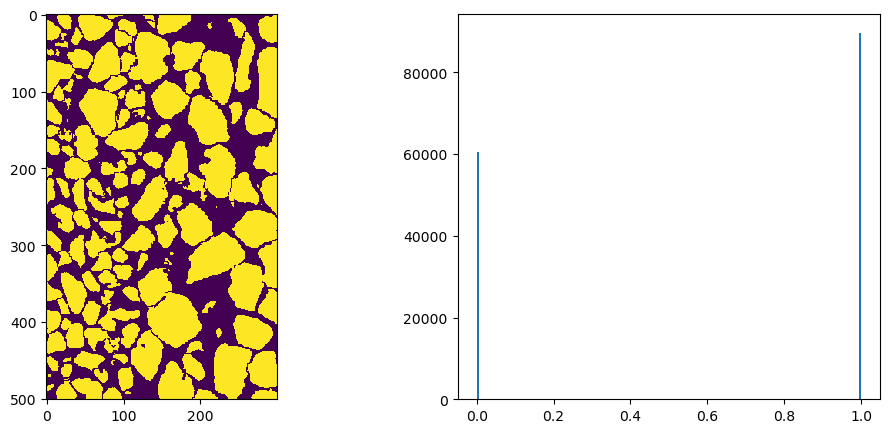

In [50]:
img=np.load('data/grains.npy')

img=img[img.shape[0]//2]
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(img,interpolation='none')
ax[1].hist(img.ravel(),bins=200);

### Noisy images
For the noisy images we add Gaussian noise with two different $\sigma$

In [ ]:
s=[0.1,0.3,0.5]
n1=img + np.random.normal(0,s[0],size=img.shape)
n2=img + np.random.normal(0,s[1],size=img.shape)
n3=img + np.random.normal(0,s[2],size=img.shape)

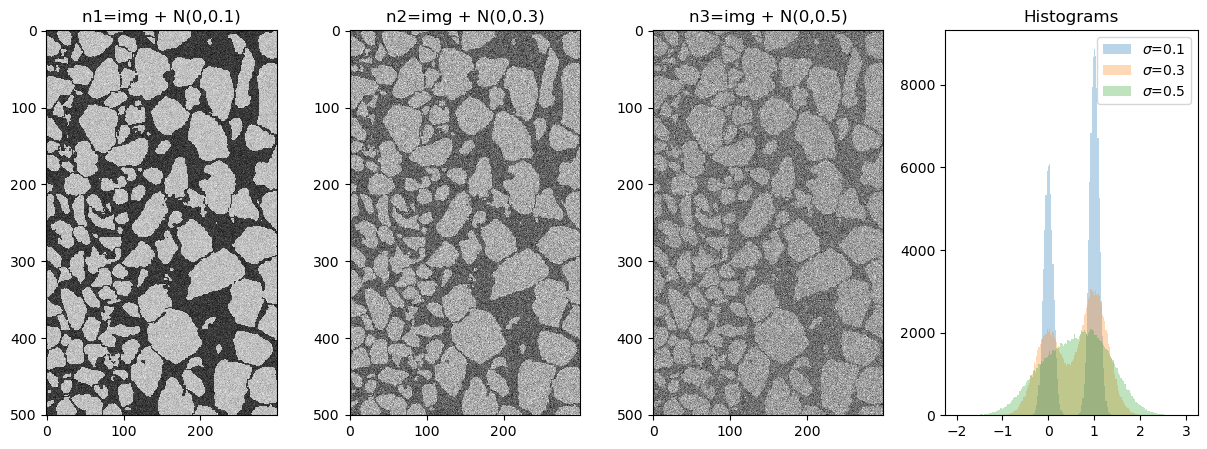

In [56]:
# Visualization
fig,ax = plt.subplots(1,4,figsize=(15,5))

ax[0].imshow(n1,interpolation='none',cmap='gray')
ax[0].set_title(r'n1=img + N(0,{0})'.format(s[0]))

ax[1].imshow(n2,interpolation='none',cmap='gray');
ax[1].set_title(r'n2=img + N(0,{0})'.format(s[1]));
ax[2].imshow(n3,interpolation='none',cmap='gray');
ax[2].set_title(r'n3=img + N(0,{0})'.format(s[2]));

bins=np.linspace(-2,3,200)
ax[3].hist(n1.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[0]))
ax[3].hist(n2.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[1]))
ax[3].hist(n3.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[2]))
ax[3].legend()
ax[3].set_title('Histograms');

As you can see here, the two peaks in the histograms overlap more for lower signal to noise ratio. This is a fact that make life harder when you try to segment the images.

## Thresholding methods
Thresholding is a technique to segment images by comparing the pixel values to a constant, $\gamma$, and assign the class of the pixel depending on whether it is less or greater than the constant value.

$$b(x)=\begin{cases}0&img(x)<\gamma\\
    1&\gamma\leq img(x)\end{cases} \forall x \in \Omega_{img}$$

_i.e._ basic thresholding is a pixel wise operation. Below, we will look at some techniques to find the threshold.

### Manual tresholding using the histogram
With manual threshoding, you decide where to put the threshold. This decision is mostly guided by inspecting the histogram. The logic choise is to place it in the middle between the two peaks in the histogram. Let's try this on our three test images.

We will also use manual thresholds to better understand the consequences of setting the threshold to different values within the graylevel distribution.

In [ ]:
gamma = 0.5
b1    = gamma<=n1
b2    = gamma<=n2
b3    = gamma<=n3

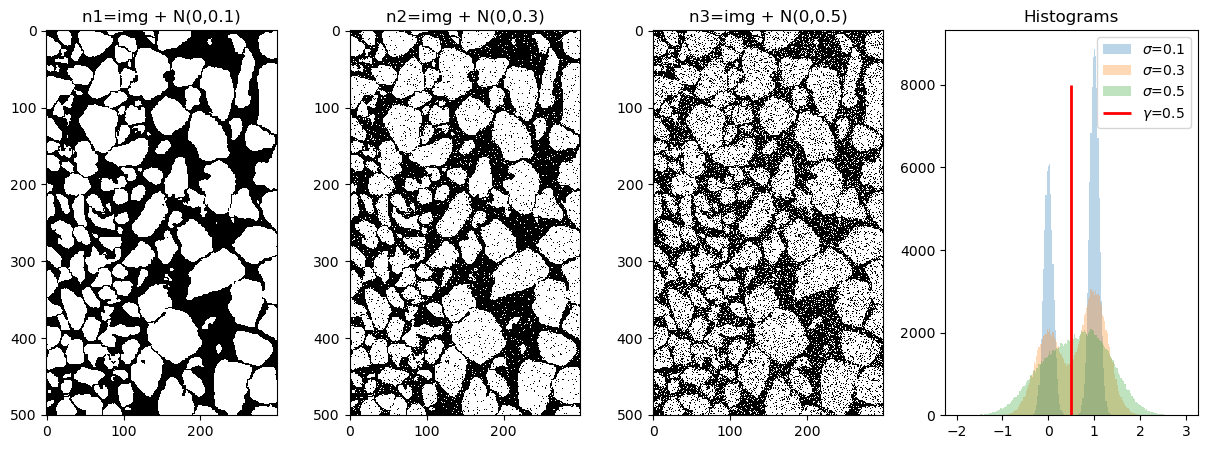

In [59]:
# Visualization
fig,ax = plt.subplots(1,4,figsize=(15,5))

ax[0].imshow(b1,interpolation='none',cmap='gray')
ax[0].set_title(r'n1=img + N(0,{0})'.format(s[0]))

ax[1].imshow(b2,interpolation='none',cmap='gray');
ax[1].set_title(r'n2=img + N(0,{0})'.format(s[1]));
ax[2].imshow(b3,interpolation='none',cmap='gray');
ax[2].set_title(r'n3=img + N(0,{0})'.format(s[2]));

bins=np.linspace(-2,3,200)
ax[3].hist(n1.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[0]))
ax[3].hist(n2.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[1]))
ax[3].hist(n3.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[2]))
ax[3].vlines([gamma],ymin=0,ymax=8000,label='$\gamma$={0}'.format(gamma),lw=2,color='r')
ax[3].legend()
ax[3].set_title('Histograms');

In this example you can see that the thresholding doesn't provide that good result for images $n2$ and $n3$. The reason is that the noise distributions overlap between the two classes. This has the consequence that we incorrectly assign some pixels as background and foreground respectively. 

Now let's see what happens when move the threshold level to different values, e.g. $\gamma$={0.0,0.25, 0.75, 1.0}.

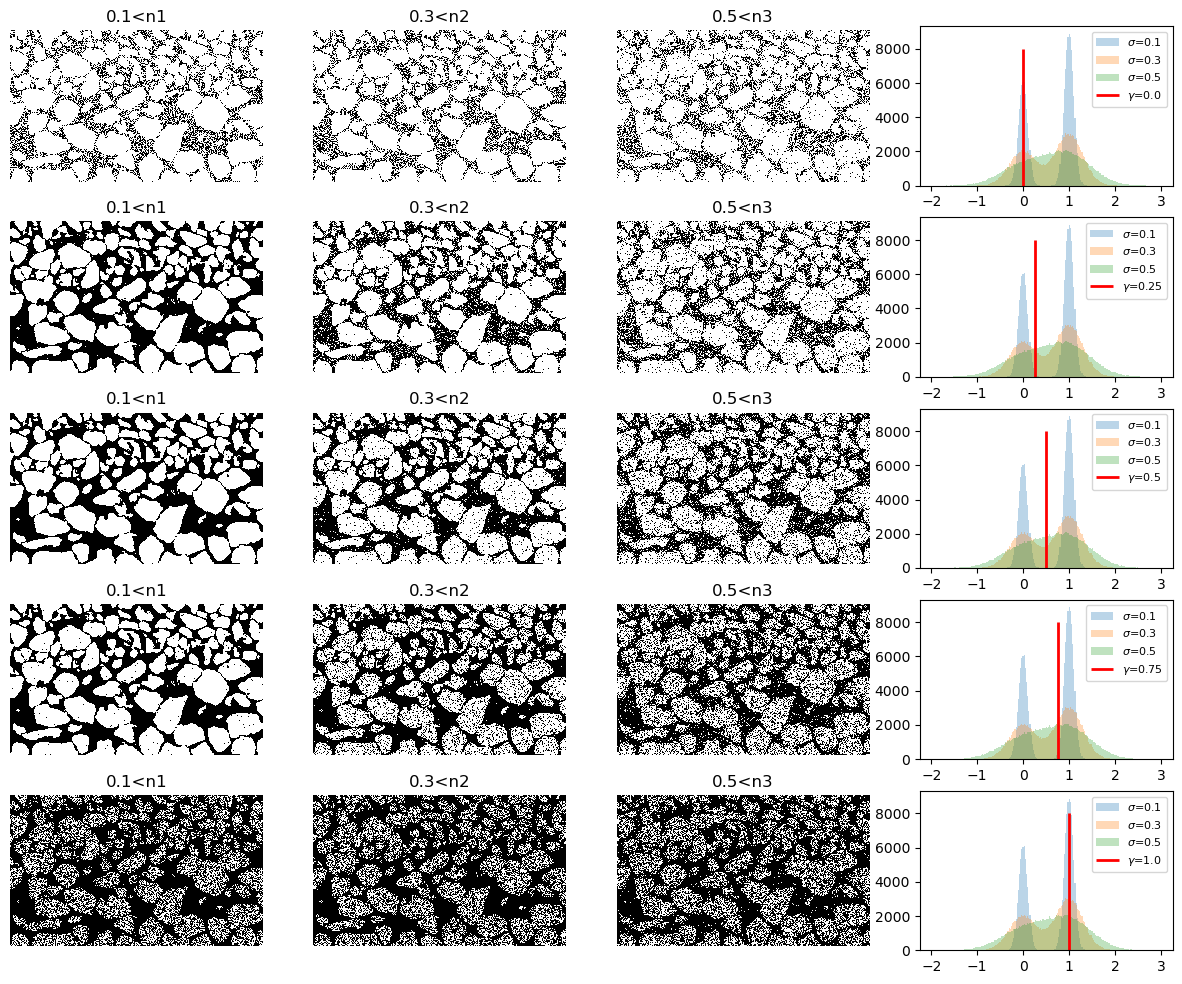

In [65]:
gamma = [0.0, 0.25, 0.5 ,0.75, 1.0]

# Visualization
fig,axes = plt.subplots(len(gamma),4,figsize=(15,12))

for ax,gamma in zip(axes,gamma) :
    # Thresholding using new gamma
    b1    = gamma<=n1
    b2    = gamma<=n2
    b3    = gamma<=n3
    
    # Show the result
    ax[0].imshow(b1.transpose(),interpolation='none',cmap='gray')
    ax[0].set_title(r'{0}<n1'.format(s[0]))
    ax[0].axis('off')
    ax[1].imshow(b2.transpose(),interpolation='none',cmap='gray');
    ax[1].set_title(r'{0}<n2'.format(s[1]));
    ax[1].axis('off')
    ax[2].imshow(b3.transpose(),interpolation='none',cmap='gray');
    ax[2].set_title(r'{0}<n3'.format(s[2]));
    ax[2].axis('off')
    
    bins=np.linspace(-2,3,200)
    ax[3].hist(n1.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[0]))
    ax[3].hist(n2.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[1]))
    ax[3].hist(n3.ravel(),bins=bins,alpha=0.3,label=r'$\sigma$={0}'.format(s[2]))
    ax[3].vlines([gamma],ymin=0,ymax=8000,label='$\gamma$={0}'.format(gamma),lw=2,color='r')
    ax[3].legend(fontsize=8);

In this sequence of thresholds, you can see that it is important to find the correct threshold to avoid too many misclassified pixels. This is off course particularly important for low SNR images.

A further observation is that a threshold is closer to the left peak you get more forground pixels. Analogously, more background pixels are assigned when the threshold is closer to the right peak.

Next step is to use algorithms to find the threshold for us. This has the advantage that the result is reproducible for data with the same noise distribution and not left the arbitrary decision of the person who analyses the images. 

### Intermode threshold

Intermode thresholds are based on the concept of finding the peaks of two classes and selecting the threshold as the average of their positions.

$\gamma=\frac{Peak_{high}+Peak_{low}}{2}$

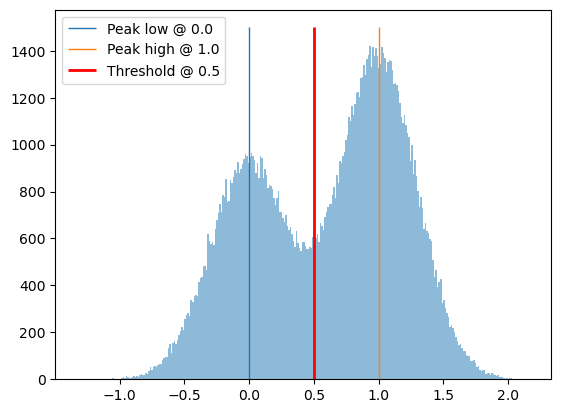

In [72]:
plt.hist(n2.ravel(), bins=300,alpha=0.5);
plt.vlines([0],ymin=0,ymax=1500,color=colors[0],lw=1,label='Peak low @ 0.0')
plt.vlines([1],ymin=0,ymax=1500,color=colors[1],lw=1,label='Peak high @ 1.0')
plt.vlines([0.5],ymin=0,ymax=1500,color='r',lw=2,label='Threshold @ 0.5')
plt.legend();

In [ ]:
b1 = flt.threshold_mean() 

### Otsu threshold
The method described by Otsu ni 1978 is probably the most used histogram-based thresholding method. It is based on the concept of minimizing the variance of each class and maximizing the variance between the classes. This produces a cost function that provides the optimal threshold at the maximum.

### Triangle threshold

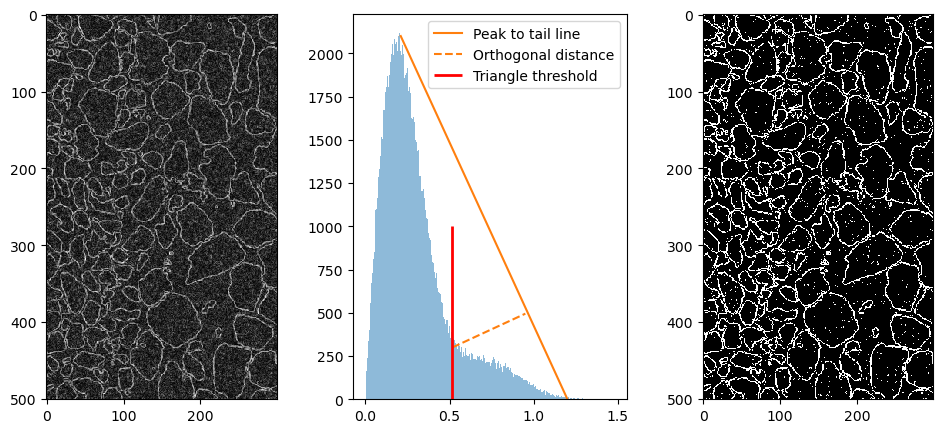

In [131]:
e2  = flt.sobel(n2)
tri = flt.threshold_triangle(e2.ravel())
b   = tri<e2

# Visualization
fig,ax=plt.subplots(1,3,figsize=(12,5))
ax[0].imshow(e2,interpolation='none',cmap='gray')
ax[1].hist(e2.ravel(),bins=300,alpha=0.5);
ax[2].imshow(b,interpolation='none',cmap='gray')
ax[1].plot([0.21,1.2],[2100,0],c=colors[1],label='Peak to tail line')
ax[1].plot([tri,0.95],[300,495],'--',c=colors[1],label='Orthogonal distance')
ax[1].vlines([tri],ymin=0,ymax=1000,color='red',lw=2,label='Triangle threshold')
ax[1].legend();

### Threshold with hysteresis

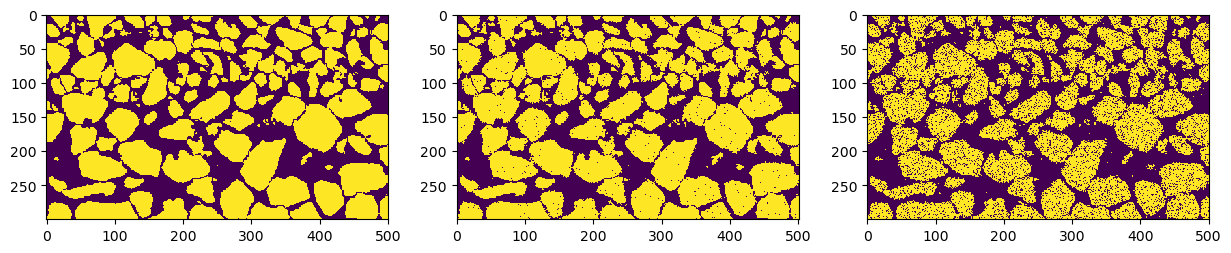

In [87]:
low  = [0.3,0.3,0.5]
high = [1,1,1.5]
imgs = [n1,n2,n3]
fig,axes = plt.subplots(1,3,figsize=(15,5))
for ax,n,th_low,th_high in zip(axes,imgs,low,high) :
    b=flt.apply_hysteresis_threshold(n, th_low, th_high)
    ax.imshow(b.transpose(),interpolation='none')


## Thresholding at low SNR

### Overlapping classes

### Misclassified pixels

### Measuring the segmentation performance

#### A ground truth is needed

#### Counting hits and misses - the confusion matrix

## Morphological image processing
We have now seen that there may be quite many misclassified pixels in segmented images. This can be handled by improving the SNR of the image before as a post processing step after segmenation. Each has it benefits and often both methods are combined to obtain the best result.

Mophological image processing introduces a new set of filters. These are essentially based on the local min and max operations instead of weighted sums. 

### The fundamental operations

- Erosion - $\varepsilon_{SE}(f)$ - shrinks the object in the image by computing the local max of the neighborhood.
- Dilation - $\delta_{SE}(f)$ - grows the objects in the image by computing the local max of the neighborhood.

The structure element _SE_ describes which neighboodhood pixels to compare with. A 'one' means that the pixel is part of the neighborhood and a 'zero' is ignored.

First we need an image to test the $\varepsilon$ and $\delta$ operations on. In this case we build our own image as an array of ones and zeros. There are three regions in the image.

In [ ]:
f=np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
            [0,0,0,0,1,1,1,0,0,1,0,0,0,0,0],
            [0,0,0,0,1,1,1,0,1,1,0,0,0,0,0],
            [0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
            [0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
            [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,1,1,1,0,0,0],
            [0,0,0,0,0,0,0,0,0,1,1,1,1,0,0],
            [0,0,0,0,0,0,0,0,0,1,1,1,1,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

The operators have the subscript _SE_ whicch stands for structure element sometimes also called footprint. This is the pattern the operations use to compare the neighborhood around the current pixel. In this example, we will use two different SE's and compare the resulting images. The SE's both have the size 3$\times$3 and the box has all elements set to one while the cross has the corners replaced by zeros to form a cross.

We use the variable _se_ to select the SE in the next cell.

In [32]:
box   = np.ones([3,3])
cross = np.array([[0,1,0],
                 [1,1,1],
                 [0,1,0]])

se = box
# se = cross

Now we try erosion and dilation on test image $f$ and see what happens. 

In [ ]:
e = morph.erosion(f,se)
d = morph.dilation(f,se)

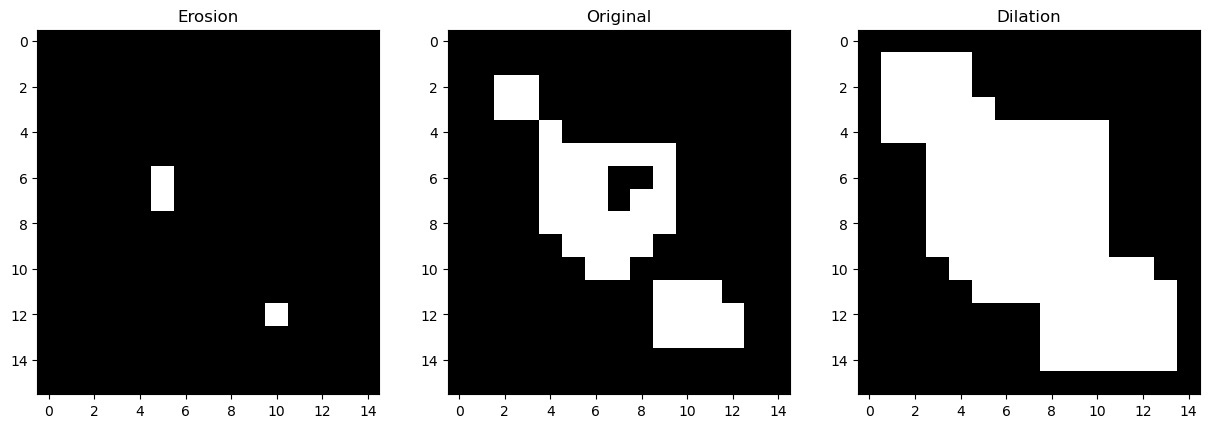

In [35]:
# Visualization only
fig,ax = plt.subplots(1,3,figsize=(15,5))
plt.imshow(f,interpolation='none',cmap='gray')

ax[0].imshow(e,interpolation='none',cmap='gray')
ax[0].set_title('Erosion')
ax[1].imshow(f,interpolation='none',cmap='gray')
ax[1].set_title('Original')
ax[2].imshow(d,interpolation='none',cmap='gray')
ax[2].set_title('Dilation');

Now change to the other SE and observe what happens. 

__Questions__
1. Which SE changes the item shapes more in the image?
2. Why is that so?

### Combined operations
It is mostly too drastic to apply a single morphologic operator. The object shapes change too much!

This can be handled by using a sequence of operations
- Opening - $\phi_{SE}(f) = \delta_{SE}(\varepsilon_{SE}(f))$
- Closing - $\gamma_{SE}(f) = \varepsilon_{SE}(\delta_{SE}(f))$

In the example below, we use opening and closing on the same image as above. Try the effect of different SE shapes by uncommenting the cross.

In [ ]:
se = box
# se = cross

o = morph.opening(f,se)
c = morph.closing(f,se)

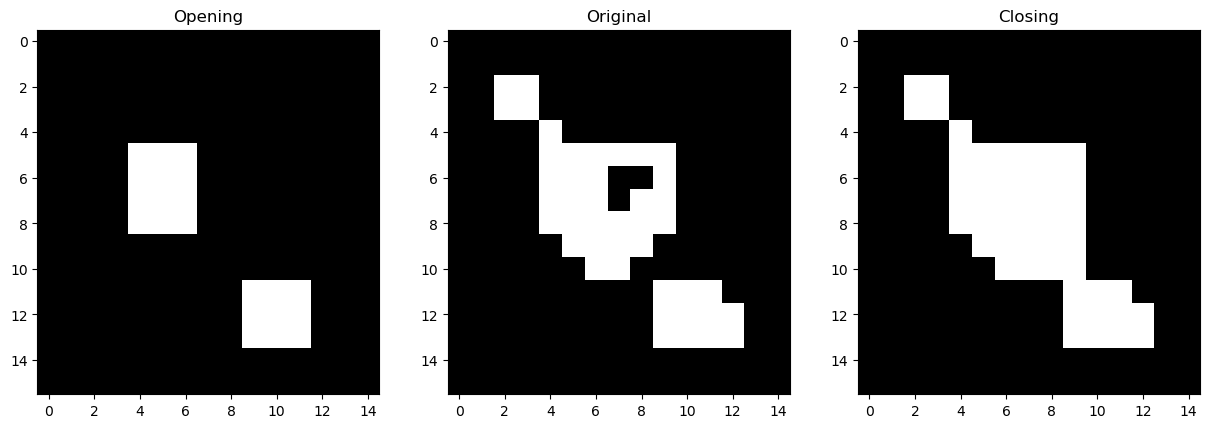

In [34]:
# Visualization only
fig,ax = plt.subplots(1,3,figsize=(15,5))
plt.imshow(f,interpolation='none',cmap='gray')

ax[0].imshow(o,interpolation='none',cmap='gray')
ax[0].set_title('Opening')
ax[1].imshow(f,interpolation='none',cmap='gray')
ax[1].set_title('Original')
ax[2].imshow(c,interpolation='none',cmap='gray')
ax[2].set_title('Closing');

### Choosing the right size of the SE
The size and shape of the SE has a clear effect on the processed image. 

### Using morphological operations to clean up segmented images

### The confusion matrix after opening and closing

## Summary

In this tutorial we learned
- How a bi-level image can be obtained using thresholds
- The threshold can be found using several algorithms. The choice depends on the characteristics of the data. 
- Thresholding often produces misclassified pixels.
- The confusion matrix can be used to visualize the degree of misclassifications if you have a ground truth image.
- Morphological opening and closing can be used to clean-up the thresholded images and reduce the number of misclassified pixels.